### Prerequisite Packages

In [1]:
import sys
import os
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
sys.path.append('../')

from modules.cross_attentionb import CrossAttentionB
from modules.dataloader import load_npy_files
from modules.classifier import DenseLayer, BCELoss, CustomLoss, BCEWithLogits, FocalLoss
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [3]:
torch.manual_seed(42)

# Define all possible modality assignments
modality_configurations = {
    'ATV': {
        'modalityAlpha': 'audio_features',
        'modalityBeta': 'text_features',
        'modalityGamma': 'video_features'
    },
    'AVT': {
        'modalityAlpha': 'audio_features',
        'modalityBeta': 'video_features',
        'modalityGamma': 'text_features'
    },
    'TVA': {
        'modalityAlpha': 'text_features',
        'modalityBeta': 'video_features',
        'modalityGamma': 'audio_features'
    }
}

# Function to get the modality assignments by configuration name
def get_modality_assignments(config_name):
    if config_name in modality_configurations:
        return modality_configurations[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found.")
    
    
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/audio_features/logmel',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [4]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Modality Assignment: 'ATV', 'AVT', 'TVA'
selected_config = 'AVT'
modality_assignments = get_modality_assignments(selected_config)

### Audio Feature selection: 'logmel' or 'mfcc'
selected_config = 'logmel'
audio_features_dir = get_audio_feature_path(selected_config)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data

#FIXED CONSTANT
max_pad = 197

### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-5         # For optimizer
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.4       # for MutualCrossAttention
num_epochs = 10              # for model training

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits().to(device)
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = True

### For cross validation
num_folds = 5          # Set the number of folds for cross-validation
num_epochs_cv = 10     # Set the number of epochs for cross-validation

Device: cuda


### Dataset Class

In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}

        # List to store missing files
        self.missing_files = []

        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']

        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping
        label_map = {'red': 1, 'green': 0} 
        
        # Convert labels to tensor using label_map
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [6]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


### Data Loading


In [7]:
def filter_video_features(video_features, lower_bound=35, upper_bound=197):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


In [8]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = '../misc/text_features'
audio_features_dir = audio_features_dir
video_features_dir = '../misc/video_features'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


In [9]:
# Calculate the Q1 (25th percentile) and Q3 (75th percentile) for sequence lengths
sequence_lengths = [tensor.size(0) for _, tensor in video_features]  # Extract sequence lengths

Q1 = np.percentile(sequence_lengths, 25)
Q3 = np.percentile(sequence_lengths, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

lower_bound = 30
upper_bound = 197

# Find the outliers
outliers = []

for file, video_tensor in video_features:
    imdbid = os.path.basename(file).split('_')[0]  # Extract IMDB ID from the file name
    seq_length = video_tensor.size(0)
    
    # Check if the sequence length is an outlier
    if seq_length < lower_bound or seq_length > upper_bound:
        outliers.append((imdbid, seq_length))

# Print outliers
print("Outliers:")
for imdbid, seq_length in outliers:
    print(f"IMDB ID: {imdbid}, Sequence Length: {seq_length}")

print("Lower Bound:", lower_bound)
print("Uppder Bound:", upper_bound)
print("Number of outliers:", len(outliers))

Outliers:
Lower Bound: 30
Uppder Bound: 197
Number of outliers: 0


### Model Class

In [10]:
## MCA Class
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768).to(device)
        self.device = device

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Assign x1 and x2 to query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism formula to get intermediate output A
        scores = torch.bmm(query, key.transpose(1, 2)) / math.sqrt(d)
        output_A = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x2)
        # Basic attention mechanism formula to get intermediate output B
        scores = torch.bmm(key, query.transpose(1, 2)) / math.sqrt(d)
        output_B = torch.bmm(self.dropout(F.softmax(scores, dim=-1)), x1)

        # Make the summation of the two intermediate outputs
        output = output_A + output_B  # shape (1280, 32, 60)

        output = self.layer_norm(output)

        return output

### SMCA Functions and Model

In [11]:
def SMCAStage1(modalityAlpha, modalityBeta, d_out_kq, d_out_v, device):
    
    cross_attn = MutualCrossAttention(att_dropout_rate)

    # Cross-attention: Alpha + Beta
    alphaBeta = cross_attn(modalityAlpha, modalityBeta)  # Shape: (batch_size, num_queries, d_out_v)

    # Concatenate cross-attention outputs along the feature dimension (-1)
    return alphaBeta

In [12]:
def SMCAStage2(modalityAlphaBeta, modalityGamma, d_out_kq, d_out_v, device):
    # modalityAlphaBeta: (batch_size, seq_len, 2 * d_out_v) [output of Stage 1]

    cross_attn = MutualCrossAttention(att_dropout_rate)

    alphaBetaGamma = cross_attn(modalityAlphaBeta, modalityGamma)  # Shape: (batch_size, seq_len_alphaBeta, d_out_v)

    return alphaBetaGamma

In [13]:
class SMCAModel(nn.Module):
    def __init__(self, d_out_kq, d_out_v, device):
        super(SMCAModel, self).__init__()
        self.d_out_kq = d_out_kq
        self.d_out_v = d_out_v
        self.device = device
    
    def forward(self, modalityAlpha, modalityBeta, modalityGamma):
        # Stage 1: Cross attention between modalityAlpha and modalityBeta
        modalityAlphaBeta = SMCAStage1(modalityAlpha, modalityBeta, self.d_out_kq, self.d_out_v, self.device)

        # Stage 2: Cross attention with modalityAlphaBeta (as query) and modalityGamma (as key-value)
        multimodal_representation = SMCAStage2(modalityAlphaBeta, modalityGamma, self.d_out_kq, self.d_out_v, self.device)

        return multimodal_representation

In [14]:
def pad_features(features, max_pad=max_pad):
    # Pad or trim the sequence dimension to `max_pad`
    if features.size(1) < max_pad:
        # Pad to the right along the sequence dimension
        features = F.pad(features, (0, 0, 0, max_pad - features.size(1)))
    elif features.size(1) == max_pad:
        pass
    else:
        # Trim if the sequence is longer than `max_pad`
        features = features[:, :max_pad, :]
        print("VIDEO TRIMMED SOMETHING MAY MALI")
    return features

### Classifier

In [15]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=cl_dropout_rate):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 3072)  # First fully connected layer
        self.fc2 = nn.Linear(3072, 768)          # Second fully connected layer
        # self.fc3 = nn.Linear(768, 128)          # Third fully connected layer
        # self.fc4 = nn.Linear(128, 64)          # Second fully connected layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(768, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        # x = self.fc3(x)                         # third fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation

        # x = self.fc4(x)                         # fourth fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation
        # x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        if isBCELoss:
            x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


### Model Training Functions

In [ ]:
def train_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    optimizer, 
    device,
    output_dir='results/', 
    output_filename='train_predictions.csv',
    output_dim=768
):
    # model.train()
    dense_layer.train()
    total_loss = 0.0
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    # List to collect results for CSV
    results = []
    


    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        text_features, audio_features, video_features, targets = (
            text_features.to(device),
            audio_features.to(device),
            video_features.to(device),
            targets.to(device).view(-1)
        )
                
        # Squeeze the audio features to remove the extra dimension
        audio_features = audio_features.squeeze(1).to(device) 
        text_features = text_features.unsqueeze(1).to(device) 

        # Apply linear transformations to match dimensions
        linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
        text_features = linear_transform_text(text_features).to(device) 
        
        audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)   # Resulting shape: [batch_size, 1, 768]

        video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

        transformed_features = {
            'audio_features': audio_features,
            'text_features': text_features,
            'video_features': video_features
        }

        outputs = model(
            modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device) ,  # Use the dictionary for modality assignment
            modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device) ,
            modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device) 
        ).to(device)

        outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

        # Pass the fused features through the dense layer
        predictions = dense_layer(outputs).view(-1)

        # Compute loss
        loss = criterion(predictions, targets)
        total_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # !!!Apply if BCEWithLogits or CustomLoss!!!
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)

        # Apply threshold to get binary predictions
        preds = (predictions >= threshold).float()
        
        # Collect results for each sample
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': preds[i].item(),
                'Target': targets[i].item()
            })
        
        # Update metrics for binary classification
        precision_metric.update(preds.long(), targets.long())
        recall_metric.update(preds.long(), targets.long())
        f1_metric.update(preds.long(), targets.long())
        accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()  # Compute accuracy
    
    train_average_loss = total_loss / len(dataloader)
    

    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [ ]:
def evaluate_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/', 
    output_filename='val_predictions.csv',
    output_dim=768
):
    model.eval()
    dense_layer.eval()
    total_loss = 0.0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of training
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()
    
    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    

    
    with torch.no_grad():
         for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
        
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device)
            text_features = text_features.unsqueeze(1).to(device)

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)   
            text_features = linear_transform_text(text_features).to(device)
            
            audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)  # Resulting shape: [batch_size, 1, 768]
    
            video_features = pad_features(video_features).to(device)  # Shape will be [batch_size, max_pad, 768]
                    
            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device),  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device),
                modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device)
            )

            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

    # Compute average precision, recall, F1 score, and accuracy
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item() 
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    val_average_loss = total_loss / len(dataloader)
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [ ]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/', 
    output_filename='test_predictions.csv',
    output_dim=768
):
    model.eval()
    dense_layer.eval()
    total_loss = 0

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 

    all_predictions = []
    all_targets = []
    
    # List to collect results for CSV
    results = []
    


    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device).view(-1)
            )
            
            # Squeeze the audio features to remove the extra dimension
            audio_features = audio_features.squeeze(1).to(device) 
            text_features = text_features.unsqueeze(1).to(device) 

            # Apply linear transformations to match dimensions
            linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
            text_features = linear_transform_text(text_features).to(device) 
            
            audio_features = audio_features[:, -1, :].unsqueeze(1).to(device)   # Resulting shape: [batch_size, 1, 768]
    
            video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

            transformed_features = {
                'audio_features': audio_features,
                'text_features': text_features,
                'video_features': video_features
            }

            outputs = model(
                modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device) ,  # Use the dictionary for modality assignment
                modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device) ,
                modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device) 
            )
    
            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]

            # Pass the fused features through the dense layer
            predictions = dense_layer(outputs).view(-1)
                
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # !!!Apply if BCEWithLogits or CustomLoss!!!
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()
            
            # Collect predictions and targets for the confusion matrix
            all_predictions.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long()) 

     # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item()
    
    # Generate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, all_predictions)

    test_average_loss = total_loss / len(dataloader)
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix

In [39]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

### Model Training

In [40]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [41]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
if __name__ == "__main__":
    torch.manual_seed(42)

    # Initialize the SMCA model A
    model = SMCAModel(768, 768, device).to(device)  # Dimension for d_out_kq and d_out_v

    # Determine the output dimensions
    output_dim = 768

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim * max_pad).to(device) 
    else:
        dense_layer = DenseLayer(output_dim).to(device)

    optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device, output_dim=output_dim)
        train_losses.append(train_average_loss)  # Store training loss

        print("-" * 20, "Train", "-" * 20)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}")
        print(f"Train F1 Score: {train_f1_score:.4f}")
        print(f"Train Loss: {train_average_loss:.4f}")
    
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device, output_dim=output_dim)
        val_losses.append(val_average_loss)  # Store validation loss
        
        print("-" * 20, "Eval", "-" * 20)
        print(f"Eval Accuracy: {val_accuracy:.4f}")
        print(f"Eval Precision: {val_precision:.4f}")
        print(f"Eval Recall: {val_recall:.4f}")
        print(f"Eval F1 Score: {val_f1_score:.4f}")
        print(f"Eval Loss: {val_average_loss:.4f}")
        
        # print(f"Training Loss: {train_average_loss:.4f}, Validation Loss: {eval_average_loss:.4f}")

    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device, output_dim=output_dim)
    
    print("-" * 20, "Test", "-" * 20)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [val_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [val_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)
    

----------------------------------------
Epoch 1/10


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.73 GiB. GPU 

### Results Monitoring

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
plot_confusion_matrix(test_conf_matrix)

In [ ]:
# Display the table
metrics_df

In [ ]:
# Print sizes of each DataLoader (FOR CHECKING)
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")


Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


In [27]:
train_df = pd.read_csv('results/train_predictions.csv')
train_df


,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt5292624,0.736823,1.0,1.0
1,tt1996264,0.887823,1.0,1.0
2,tt0110157,0.004624,0.0,0.0
3,tt0259711,0.053281,0.0,0.0
4,tt0758774,0.267036,0.0,0.0
...,...,...,...,...
1055,tt0328538,0.276780,0.0,0.0
1056,tt0082367,0.817319,1.0,1.0
1057,tt1366344,0.562297,1.0,1.0
1058,tt7634968,0.684587,1.0,1.0


In [28]:
eval_df = pd.read_csv('results/val_predictions.csv')
eval_df

,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt0300620,0.044776,0.0,0.0
1,tt0117333,0.024099,0.0,0.0
2,tt0101414,0.006145,0.0,0.0
3,tt2557490,0.274969,0.0,1.0
4,tt5918982,0.888453,1.0,1.0
...,...,...,...,...
260,tt1331064,0.025512,0.0,0.0
261,tt0483607,0.097614,0.0,0.0
262,tt0102288,0.020075,0.0,0.0
263,tt0448564,0.004929,0.0,0.0


In [29]:
test_df = pd.read_csv('results/test_predictions.csv')
test_df

,IMDBid,Raw Prediction,Binary Prediction,Target
0,tt6261048,0.091161,0.0,0.0
1,tt1596346,0.197217,0.0,0.0
2,tt0809504,0.114703,0.0,0.0
3,tt0472562,0.336006,0.0,0.0
4,tt0134033,0.053163,0.0,0.0
...,...,...,...,...
194,tt0770806,0.683721,1.0,0.0
195,tt0311941,0.239854,0.0,1.0
196,tt2072233,0.834122,1.0,1.0
197,tt1178640,0.190963,0.0,0.0


### Cross-Validation

In [30]:
def plot_average_loss_curves(train_losses_folds, val_losses_folds):
    # Transpose folds to calculate averages per epoch
    num_epochs = len(train_losses_folds[0])
    avg_train_losses = [np.mean([fold[epoch] for fold in train_losses_folds]) for epoch in range(num_epochs)]
    avg_val_losses = [np.mean([fold[epoch] for fold in val_losses_folds]) for epoch in range(num_epochs)]

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_losses, label='Average Training Loss', color='blue', marker='o')
    plt.plot(epochs, avg_val_losses, label='Average Validation Loss', color='orange', marker='o')
    
    plt.title('Average Training and Validation Loss Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:

def cross_validate_model(
    dataset, 
    model_class, 
    dense_layer_class, 
    num_folds, 
    num_epochs, 
    output_dim,
    criterion,
    learning_rate,
    train_batch_size,
    val_batch_size,
    output_file,
    device=None
):
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    fold_losses = []
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    
    # Lists to store metrics and losses for each fold
    train_losses_folds = []  # List of lists: train_losses_folds[fold][epoch]
    val_losses_folds = []    # List of lists: val_losses_folds[fold][epoch]
    
    # Perform K-Fold Cross-Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print("-" * 60)
        print(f"------------------------- Fold {fold + 1 }/{num_folds} -------------------------")

        # Create data loaders for the train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=train_batch_size, sampler=train_sampler, collate_fn=collate_fn)
        val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=val_batch_size, sampler=val_sampler, collate_fn=collate_fn)
        
        print_dataloader_sizes(train_dataloader, "Train")
        print_dataloader_sizes(val_dataloader, "Validation")
        
        # Initialize the model, dense layer, criterion, and optimizer for each fold
        model = model_class(768, 768, device).to(device)
        
        dense_layer = dense_layer_class(output_dim * max_pad).to(device)
        criterion = criterion.to(device)
        optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)

        # Initialize lists to track losses for this fold
        train_losses = []
        val_losses = []
        
        # Use tqdm for progress bar
        epoch_progress = tqdm(range(num_epochs), desc=f"Fold {fold + 1}/{num_folds} Training", leave=True)


        # Training loop for each fold
        for epoch in epoch_progress:
            print(f"------------------------- Epoch {epoch + 1}/{num_epochs} -------------------------")
            
            # Train and evaluate the model on the training and validation sets
            train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device)
            val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device)
            
            # Track losses for this fold and epoch
            train_losses.append(train_average_loss)
            val_losses.append(val_average_loss)
            
            print(f"\nTrain Accuracy: {train_accuracy:.4f}")
            print(f"Train Precision: {train_precision:.4f}")
            print(f"Train Recall: {train_recall:.4f}")
            print(f"Train F1 Score: {train_f1_score:.4f}")
            print(f"Train Loss: {train_average_loss:.4f}")
            
            print(f"\nEval Accuracy: {val_accuracy:.4f}")
            print(f"Eval Precision: {val_precision:.4f}")
            print(f"Eval Recall: {val_recall:.4f}")
            print(f"Eval F1 Score: {val_f1_score:.4f}")
            print(f"Eval Loss: {val_average_loss:.4f}")

            
            # Update tqdm progress bar description
            epoch_progress.set_postfix({
                "Train Loss": f"{train_average_loss:.4f}",
                "Val Loss": f"{val_average_loss:.4f}",
                "Train F1": f"{train_f1_score:.4f}",
                "Val F1": f"{val_f1_score:.4f}",
            })
        
        # Store losses for the fold
        train_losses_folds.append(train_losses)
        val_losses_folds.append(val_losses)
           
        # Store the validation metrics for this fold
        fold_losses.append(val_average_loss)
        fold_accuracies.append(val_accuracy)
        fold_precisions.append(val_precision)
        fold_recalls.append(val_recall)
        fold_f1_scores.append(val_f1_score)

    # Calculate the average metrics across all folds
    avg_loss = np.mean(fold_losses)
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)

    print("-" * 50)
    print("\nK-Fold Cross-Validation Results:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")

    # Plot average loss curves across folds
    plot_average_loss_curves(train_losses_folds, val_losses_folds)

    
    results_dict = {"Metrics": ["Loss", "Accuracy", "Precision", "Recall", "F1 Score"]}
    for i in range(num_folds):
        results_dict[f"Fold {i + 1}"] = [fold_losses[i], fold_accuracies[i], fold_precisions[i], fold_recalls[i], fold_f1_scores[i]]
    results_dict["Average"] = [avg_loss, avg_accuracy, avg_precision, avg_recall, avg_f1_score]

    # Create DataFrame
    results_df = pd.DataFrame(results_dict)
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)  
        
    # Save results to .csv
    results_df.to_csv(output_file, index=False)
    
    return results_df

Device: cuda
------------------------------------------------------------
------------------------- Fold 1/5 -------------------------


Fold 1/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 1/5 Training:  10%|█         | 1/10 [01:52<16:55, 112.85s/it, Train Loss=0.5010, Val Loss=0.5048, Train F1=0.3592, Val F1=0.5469]

-------------------- Train --------------------
Train Accuracy: 0.7745
Train Precision: 0.6204
Train Recall: 0.2528
Train F1 Score: 0.3592
Train Loss: 0.5010
-------------------- Eval --------------------
Eval Accuracy: 0.7811
Eval Precision: 0.5932
Eval Recall: 0.5072
Eval F1 Score: 0.5469
Eval Loss: 0.5048
------------------------- Epoch 2/10 -------------------------


Fold 1/5 Training:  20%|██        | 2/10 [03:51<15:30, 116.36s/it, Train Loss=0.3945, Val Loss=0.5417, Train F1=0.6316, Val F1=0.5730]

-------------------- Train --------------------
Train Accuracy: 0.8415
Train Precision: 0.7539
Train Recall: 0.5434
Train F1 Score: 0.6316
Train Loss: 0.3945
-------------------- Eval --------------------
Eval Accuracy: 0.7132
Eval Precision: 0.4679
Eval Recall: 0.7391
Eval F1 Score: 0.5730
Eval Loss: 0.5417
------------------------- Epoch 3/10 -------------------------


Fold 1/5 Training:  30%|███       | 3/10 [05:43<13:21, 114.44s/it, Train Loss=0.3727, Val Loss=0.4341, Train F1=0.6500, Val F1=0.5902]

-------------------- Train --------------------
Train Accuracy: 0.8415
Train Precision: 0.7256
Train Recall: 0.5887
Train F1 Score: 0.6500
Train Loss: 0.3727
-------------------- Eval --------------------
Eval Accuracy: 0.8113
Eval Precision: 0.6792
Eval Recall: 0.5217
Eval F1 Score: 0.5902
Eval Loss: 0.4341
------------------------- Epoch 4/10 -------------------------


Fold 1/5 Training:  40%|████      | 4/10 [07:40<11:31, 115.26s/it, Train Loss=0.3386, Val Loss=0.4141, Train F1=0.6837, Val F1=0.6230]

-------------------- Train --------------------
Train Accuracy: 0.8594
Train Precision: 0.7816
Train Recall: 0.6075
Train F1 Score: 0.6837
Train Loss: 0.3386
-------------------- Eval --------------------
Eval Accuracy: 0.8264
Eval Precision: 0.7170
Eval Recall: 0.5507
Eval F1 Score: 0.6230
Eval Loss: 0.4141
------------------------- Epoch 5/10 -------------------------


Fold 1/5 Training:  50%|█████     | 5/10 [09:33<09:32, 114.56s/it, Train Loss=0.3198, Val Loss=0.4583, Train F1=0.6857, Val F1=0.5812]

-------------------- Train --------------------
Train Accuracy: 0.8547
Train Precision: 0.7467
Train Recall: 0.6340
Train F1 Score: 0.6857
Train Loss: 0.3198
-------------------- Eval --------------------
Eval Accuracy: 0.8151
Eval Precision: 0.7083
Eval Recall: 0.4928
Eval F1 Score: 0.5812
Eval Loss: 0.4583
------------------------- Epoch 6/10 -------------------------


Fold 1/5 Training:  60%|██████    | 6/10 [11:28<07:38, 114.66s/it, Train Loss=0.2985, Val Loss=0.4322, Train F1=0.7307, Val F1=0.5763]

-------------------- Train --------------------
Train Accuracy: 0.8783
Train Precision: 0.8178
Train Recall: 0.6604
Train F1 Score: 0.7307
Train Loss: 0.2985
-------------------- Eval --------------------
Eval Accuracy: 0.8113
Eval Precision: 0.6939
Eval Recall: 0.4928
Eval F1 Score: 0.5763
Eval Loss: 0.4322
------------------------- Epoch 7/10 -------------------------


Fold 1/5 Training:  70%|███████   | 7/10 [13:25<05:45, 115.26s/it, Train Loss=0.2806, Val Loss=0.4932, Train F1=0.7280, Val F1=0.4255]

-------------------- Train --------------------
Train Accuracy: 0.8774
Train Precision: 0.8169
Train Recall: 0.6566
Train F1 Score: 0.7280
Train Loss: 0.2806
-------------------- Eval --------------------
Eval Accuracy: 0.7962
Eval Precision: 0.8000
Eval Recall: 0.2899
Eval F1 Score: 0.4255
Eval Loss: 0.4932
------------------------- Epoch 8/10 -------------------------


Fold 1/5 Training:  80%|████████  | 8/10 [15:12<03:45, 112.69s/it, Train Loss=0.2939, Val Loss=0.4291, Train F1=0.7360, Val F1=0.5984]

-------------------- Train --------------------
Train Accuracy: 0.8755
Train Precision: 0.7830
Train Recall: 0.6943
Train F1 Score: 0.7360
Train Loss: 0.2939
-------------------- Eval --------------------
Eval Accuracy: 0.8075
Eval Precision: 0.6552
Eval Recall: 0.5507
Eval F1 Score: 0.5984
Eval Loss: 0.4291
------------------------- Epoch 9/10 -------------------------


Fold 1/5 Training:  90%|█████████ | 9/10 [17:00<01:51, 111.37s/it, Train Loss=0.2896, Val Loss=0.4220, Train F1=0.7455, Val F1=0.6528]

-------------------- Train --------------------
Train Accuracy: 0.8802
Train Precision: 0.7949
Train Recall: 0.7019
Train F1 Score: 0.7455
Train Loss: 0.2896
-------------------- Eval --------------------
Eval Accuracy: 0.8113
Eval Precision: 0.6267
Eval Recall: 0.6812
Eval F1 Score: 0.6528
Eval Loss: 0.4220
------------------------- Epoch 10/10 -------------------------


Fold 1/5 Training: 100%|██████████| 10/10 [18:50<00:00, 113.05s/it, Train Loss=0.3150, Val Loss=0.4174, Train F1=0.6949, Val F1=0.6129]

-------------------- Train --------------------
Train Accuracy: 0.8575
Train Precision: 0.7478
Train Recall: 0.6491
Train F1 Score: 0.6949
Train Loss: 0.3150
-------------------- Eval --------------------
Eval Accuracy: 0.8189
Eval Precision: 0.6909
Eval Recall: 0.5507
Eval F1 Score: 0.6129
Eval Loss: 0.4174
------------------------------------------------------------
------------------------- Fold 2/5 -------------------------



Fold 2/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 2/5 Training:  10%|█         | 1/10 [02:10<19:38, 130.93s/it, Train Loss=0.5270, Val Loss=0.4679, Train F1=0.3541, Val F1=0.5039]

-------------------- Train --------------------
Train Accuracy: 0.7557
Train Precision: 0.5420
Train Recall: 0.2630
Train F1 Score: 0.3541
Train Loss: 0.5270
-------------------- Eval --------------------
Eval Accuracy: 0.7623
Eval Precision: 0.5079
Eval Recall: 0.5000
Eval F1 Score: 0.5039
Eval Loss: 0.4679
------------------------- Epoch 2/10 -------------------------


Fold 2/5 Training:  20%|██        | 2/10 [04:15<16:56, 127.03s/it, Train Loss=0.4098, Val Loss=0.4206, Train F1=0.5541, Val F1=0.5714]

-------------------- Train --------------------
Train Accuracy: 0.8057
Train Precision: 0.6667
Train Recall: 0.4741
Train F1 Score: 0.5541
Train Loss: 0.4098
-------------------- Eval --------------------
Eval Accuracy: 0.8075
Eval Precision: 0.6182
Eval Recall: 0.5312
Eval F1 Score: 0.5714
Eval Loss: 0.4206
------------------------- Epoch 3/10 -------------------------


Fold 2/5 Training:  30%|███       | 3/10 [06:29<15:13, 130.43s/it, Train Loss=0.3686, Val Loss=0.4039, Train F1=0.7008, Val F1=0.5664]

-------------------- Train --------------------
Train Accuracy: 0.8623
Train Precision: 0.7844
Train Recall: 0.6333
Train F1 Score: 0.7008
Train Loss: 0.3686
-------------------- Eval --------------------
Eval Accuracy: 0.8151
Eval Precision: 0.6531
Eval Recall: 0.5000
Eval F1 Score: 0.5664
Eval Loss: 0.4039
------------------------- Epoch 4/10 -------------------------


Fold 2/5 Training:  40%|████      | 4/10 [08:51<13:28, 134.80s/it, Train Loss=0.3628, Val Loss=0.5523, Train F1=0.6517, Val F1=0.3117]

-------------------- Train --------------------
Train Accuracy: 0.8387
Train Precision: 0.7240
Train Recall: 0.5926
Train F1 Score: 0.6517
Train Loss: 0.3628
-------------------- Eval --------------------
Eval Accuracy: 0.8000
Eval Precision: 0.9231
Eval Recall: 0.1875
Eval F1 Score: 0.3117
Eval Loss: 0.5523
------------------------- Epoch 5/10 -------------------------


Fold 2/5 Training:  50%|█████     | 5/10 [11:06<11:14, 134.97s/it, Train Loss=0.4007, Val Loss=0.4013, Train F1=0.6074, Val F1=0.6429]

-------------------- Train --------------------
Train Accuracy: 0.8292
Train Precision: 0.7330
Train Recall: 0.5185
Train F1 Score: 0.6074
Train Loss: 0.4007
-------------------- Eval --------------------
Eval Accuracy: 0.8491
Eval Precision: 0.7500
Eval Recall: 0.5625
Eval F1 Score: 0.6429
Eval Loss: 0.4013
------------------------- Epoch 6/10 -------------------------


Fold 2/5 Training:  60%|██████    | 6/10 [13:19<08:56, 134.15s/it, Train Loss=0.3116, Val Loss=0.4154, Train F1=0.7202, Val F1=0.5769]

-------------------- Train --------------------
Train Accuracy: 0.8651
Train Precision: 0.7635
Train Recall: 0.6815
Train F1 Score: 0.7202
Train Loss: 0.3116
-------------------- Eval --------------------
Eval Accuracy: 0.8340
Eval Precision: 0.7500
Eval Recall: 0.4688
Eval F1 Score: 0.5769
Eval Loss: 0.4154
------------------------- Epoch 7/10 -------------------------


Fold 2/5 Training:  70%|███████   | 7/10 [15:31<06:41, 133.75s/it, Train Loss=0.3113, Val Loss=0.3714, Train F1=0.7232, Val F1=0.5946]

-------------------- Train --------------------
Train Accuracy: 0.8708
Train Precision: 0.7956
Train Recall: 0.6630
Train F1 Score: 0.7232
Train Loss: 0.3113
-------------------- Eval --------------------
Eval Accuracy: 0.8302
Eval Precision: 0.7021
Eval Recall: 0.5156
Eval F1 Score: 0.5946
Eval Loss: 0.3714
------------------------- Epoch 8/10 -------------------------


Fold 2/5 Training:  80%|████████  | 8/10 [17:44<04:26, 133.39s/it, Train Loss=0.3138, Val Loss=0.4078, Train F1=0.6960, Val F1=0.6861]

-------------------- Train --------------------
Train Accuracy: 0.8632
Train Precision: 0.8019
Train Recall: 0.6148
Train F1 Score: 0.6960
Train Loss: 0.3138
-------------------- Eval --------------------
Eval Accuracy: 0.8377
Eval Precision: 0.6438
Eval Recall: 0.7344
Eval F1 Score: 0.6861
Eval Loss: 0.4078
------------------------- Epoch 9/10 -------------------------


Fold 2/5 Training:  90%|█████████ | 9/10 [19:57<02:13, 133.24s/it, Train Loss=0.3351, Val Loss=0.4025, Train F1=0.6758, Val F1=0.6667]

-------------------- Train --------------------
Train Accuracy: 0.8443
Train Precision: 0.7197
Train Recall: 0.6370
Train F1 Score: 0.6758
Train Loss: 0.3351
-------------------- Eval --------------------
Eval Accuracy: 0.8377
Eval Precision: 0.6615
Eval Recall: 0.6719
Eval F1 Score: 0.6667
Eval Loss: 0.4025
------------------------- Epoch 10/10 -------------------------


Fold 2/5 Training: 100%|██████████| 10/10 [22:12<00:00, 133.30s/it, Train Loss=0.2786, Val Loss=0.3682, Train F1=0.7570, Val F1=0.6552]

-------------------- Train --------------------
Train Accuracy: 0.8849
Train Precision: 0.8190
Train Recall: 0.7037
Train F1 Score: 0.7570
Train Loss: 0.2786
-------------------- Eval --------------------
Eval Accuracy: 0.8491
Eval Precision: 0.7308
Eval Recall: 0.5938
Eval F1 Score: 0.6552
Eval Loss: 0.3682
------------------------------------------------------------
------------------------- Fold 3/5 -------------------------



Fold 3/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 3/5 Training:  10%|█         | 1/10 [02:43<24:32, 163.66s/it, Train Loss=0.5015, Val Loss=0.4770, Train F1=0.2992, Val F1=0.4167]

-------------------- Train --------------------
Train Accuracy: 0.7613
Train Precision: 0.5243
Train Recall: 0.2093
Train F1 Score: 0.2992
Train Loss: 0.5015
-------------------- Eval --------------------
Eval Accuracy: 0.7887
Eval Precision: 1.0000
Eval Recall: 0.2632
Eval F1 Score: 0.4167
Eval Loss: 0.4770
------------------------- Epoch 2/10 -------------------------


Fold 3/5 Training:  20%|██        | 2/10 [05:15<20:52, 156.58s/it, Train Loss=0.4299, Val Loss=0.4562, Train F1=0.5307, Val F1=0.4167]

-------------------- Train --------------------
Train Accuracy: 0.8198
Train Precision: 0.7248
Train Recall: 0.4186
Train F1 Score: 0.5307
Train Loss: 0.4299
-------------------- Eval --------------------
Eval Accuracy: 0.7887
Eval Precision: 1.0000
Eval Recall: 0.2632
Eval F1 Score: 0.4167
Eval Loss: 0.4562
------------------------- Epoch 3/10 -------------------------


Fold 3/5 Training:  30%|███       | 3/10 [07:48<18:06, 155.16s/it, Train Loss=0.3523, Val Loss=0.3860, Train F1=0.6175, Val F1=0.7114]

-------------------- Train --------------------
Train Accuracy: 0.8434
Train Precision: 0.7614
Train Recall: 0.5194
Train F1 Score: 0.6175
Train Loss: 0.3523
-------------------- Eval --------------------
Eval Accuracy: 0.8377
Eval Precision: 0.7260
Eval Recall: 0.6974
Eval F1 Score: 0.7114
Eval Loss: 0.3860
------------------------- Epoch 4/10 -------------------------


Fold 3/5 Training:  40%|████      | 4/10 [10:14<15:07, 151.26s/it, Train Loss=0.3581, Val Loss=0.3664, Train F1=0.6611, Val F1=0.7059]

-------------------- Train --------------------
Train Accuracy: 0.8472
Train Precision: 0.7182
Train Recall: 0.6124
Train F1 Score: 0.6611
Train Loss: 0.3581
-------------------- Eval --------------------
Eval Accuracy: 0.8302
Eval Precision: 0.7013
Eval Recall: 0.7105
Eval F1 Score: 0.7059
Eval Loss: 0.3664
------------------------- Epoch 5/10 -------------------------


Fold 3/5 Training:  50%|█████     | 5/10 [12:39<12:26, 149.29s/it, Train Loss=0.3520, Val Loss=0.3451, Train F1=0.6637, Val F1=0.7606]

-------------------- Train --------------------
Train Accuracy: 0.8575
Train Precision: 0.7801
Train Recall: 0.5775
Train F1 Score: 0.6637
Train Loss: 0.3520
-------------------- Eval --------------------
Eval Accuracy: 0.8717
Eval Precision: 0.8182
Eval Recall: 0.7105
Eval F1 Score: 0.7606
Eval Loss: 0.3451
------------------------- Epoch 6/10 -------------------------


Fold 3/5 Training:  60%|██████    | 6/10 [15:09<09:58, 149.54s/it, Train Loss=0.3398, Val Loss=0.3827, Train F1=0.6623, Val F1=0.7273]

-------------------- Train --------------------
Train Accuracy: 0.8557
Train Precision: 0.7692
Train Recall: 0.5814
Train F1 Score: 0.6623
Train Loss: 0.3398
-------------------- Eval --------------------
Eval Accuracy: 0.8302
Eval Precision: 0.6742
Eval Recall: 0.7895
Eval F1 Score: 0.7273
Eval Loss: 0.3827
------------------------- Epoch 7/10 -------------------------


Fold 3/5 Training:  70%|███████   | 7/10 [17:43<07:32, 150.73s/it, Train Loss=0.3309, Val Loss=0.3885, Train F1=0.6837, Val F1=0.7317]

-------------------- Train --------------------
Train Accuracy: 0.8594
Train Precision: 0.7559
Train Recall: 0.6240
Train F1 Score: 0.6837
Train Loss: 0.3309
-------------------- Eval --------------------
Eval Accuracy: 0.8340
Eval Precision: 0.6818
Eval Recall: 0.7895
Eval F1 Score: 0.7317
Eval Loss: 0.3885
------------------------- Epoch 8/10 -------------------------


Fold 3/5 Training:  80%|████████  | 8/10 [20:12<05:00, 150.47s/it, Train Loss=0.3083, Val Loss=0.3715, Train F1=0.7113, Val F1=0.6942]

-------------------- Train --------------------
Train Accuracy: 0.8698
Train Precision: 0.7727
Train Recall: 0.6589
Train F1 Score: 0.7113
Train Loss: 0.3083
-------------------- Eval --------------------
Eval Accuracy: 0.8604
Eval Precision: 0.9333
Eval Recall: 0.5526
Eval F1 Score: 0.6942
Eval Loss: 0.3715
------------------------- Epoch 9/10 -------------------------


Fold 3/5 Training:  90%|█████████ | 9/10 [22:38<02:29, 149.08s/it, Train Loss=0.2689, Val Loss=0.3694, Train F1=0.7401, Val F1=0.7132]

-------------------- Train --------------------
Train Accuracy: 0.8821
Train Precision: 0.7982
Train Recall: 0.6899
Train F1 Score: 0.7401
Train Loss: 0.2689
-------------------- Eval --------------------
Eval Accuracy: 0.8604
Eval Precision: 0.8679
Eval Recall: 0.6053
Eval F1 Score: 0.7132
Eval Loss: 0.3694
------------------------- Epoch 10/10 -------------------------


Fold 3/5 Training: 100%|██████████| 10/10 [25:06<00:00, 150.68s/it, Train Loss=0.2922, Val Loss=0.3429, Train F1=0.7104, Val F1=0.7660]

-------------------- Train --------------------
Train Accuracy: 0.8708
Train Precision: 0.7814
Train Recall: 0.6512
Train F1 Score: 0.7104
Train Loss: 0.2922
-------------------- Eval --------------------
Eval Accuracy: 0.8755
Eval Precision: 0.8308
Eval Recall: 0.7105
Eval F1 Score: 0.7660
Eval Loss: 0.3429
------------------------------------------------------------
------------------------- Fold 4/5 -------------------------



Fold 4/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 4/5 Training:  10%|█         | 1/10 [01:58<17:43, 118.22s/it, Train Loss=0.5255, Val Loss=0.3974, Train F1=0.2507, Val F1=0.6606]

-------------------- Train --------------------
Train Accuracy: 0.7462
Train Precision: 0.5172
Train Recall: 0.1654
Train F1 Score: 0.2507
Train Loss: 0.5255
-------------------- Eval --------------------
Eval Accuracy: 0.8604
Eval Precision: 0.7660
Eval Recall: 0.5806
Eval F1 Score: 0.6606
Eval Loss: 0.3974
------------------------- Epoch 2/10 -------------------------


Fold 4/5 Training:  20%|██        | 2/10 [04:01<16:08, 121.03s/it, Train Loss=0.4097, Val Loss=0.3639, Train F1=0.5644, Val F1=0.6122]

-------------------- Train --------------------
Train Accuracy: 0.8151
Train Precision: 0.7135
Train Recall: 0.4669
Train F1 Score: 0.5644
Train Loss: 0.4097
-------------------- Eval --------------------
Eval Accuracy: 0.8566
Eval Precision: 0.8333
Eval Recall: 0.4839
Eval F1 Score: 0.6122
Eval Loss: 0.3639
------------------------- Epoch 3/10 -------------------------


Fold 4/5 Training:  30%|███       | 3/10 [05:55<13:45, 117.86s/it, Train Loss=0.3807, Val Loss=0.4317, Train F1=0.6039, Val F1=0.6944]

-------------------- Train --------------------
Train Accuracy: 0.8292
Train Precision: 0.7459
Train Recall: 0.5074
Train F1 Score: 0.6039
Train Loss: 0.3807
-------------------- Eval --------------------
Eval Accuracy: 0.8340
Eval Precision: 0.6098
Eval Recall: 0.8065
Eval F1 Score: 0.6944
Eval Loss: 0.4317
------------------------- Epoch 4/10 -------------------------


Fold 4/5 Training:  40%|████      | 4/10 [07:49<11:37, 116.27s/it, Train Loss=0.3724, Val Loss=0.3623, Train F1=0.6531, Val F1=0.5833]

-------------------- Train --------------------
Train Accuracy: 0.8387
Train Precision: 0.7285
Train Recall: 0.5919
Train F1 Score: 0.6531
Train Loss: 0.3724
-------------------- Eval --------------------
Eval Accuracy: 0.8491
Eval Precision: 0.8235
Eval Recall: 0.4516
Eval F1 Score: 0.5833
Eval Loss: 0.3623
------------------------- Epoch 5/10 -------------------------


Fold 4/5 Training:  50%|█████     | 5/10 [09:42<09:36, 115.35s/it, Train Loss=0.3483, Val Loss=0.4525, Train F1=0.6667, Val F1=0.6410]

-------------------- Train --------------------
Train Accuracy: 0.8500
Train Precision: 0.7756
Train Recall: 0.5846
Train F1 Score: 0.6667
Train Loss: 0.3483
-------------------- Eval --------------------
Eval Accuracy: 0.7887
Eval Precision: 0.5319
Eval Recall: 0.8065
Eval F1 Score: 0.6410
Eval Loss: 0.4525
------------------------- Epoch 6/10 -------------------------


Fold 4/5 Training:  60%|██████    | 6/10 [11:36<07:39, 114.91s/it, Train Loss=0.3341, Val Loss=0.3431, Train F1=0.6992, Val F1=0.6263]

-------------------- Train --------------------
Train Accuracy: 0.8547
Train Precision: 0.7458
Train Recall: 0.6581
Train F1 Score: 0.6992
Train Loss: 0.3341
-------------------- Eval --------------------
Eval Accuracy: 0.8604
Eval Precision: 0.8378
Eval Recall: 0.5000
Eval F1 Score: 0.6263
Eval Loss: 0.3431
------------------------- Epoch 7/10 -------------------------


Fold 4/5 Training:  70%|███████   | 7/10 [13:30<05:43, 114.53s/it, Train Loss=0.3234, Val Loss=0.3473, Train F1=0.7097, Val F1=0.7154]

-------------------- Train --------------------
Train Accuracy: 0.8642
Train Precision: 0.7857
Train Recall: 0.6471
Train F1 Score: 0.7097
Train Loss: 0.3234
-------------------- Eval --------------------
Eval Accuracy: 0.8679
Eval Precision: 0.7213
Eval Recall: 0.7097
Eval F1 Score: 0.7154
Eval Loss: 0.3473
------------------------- Epoch 8/10 -------------------------


Fold 4/5 Training:  80%|████████  | 8/10 [15:23<03:48, 114.13s/it, Train Loss=0.2952, Val Loss=0.3432, Train F1=0.7751, Val F1=0.7111]

-------------------- Train --------------------
Train Accuracy: 0.8943
Train Precision: 0.8540
Train Recall: 0.7096
Train F1 Score: 0.7751
Train Loss: 0.2952
-------------------- Eval --------------------
Eval Accuracy: 0.8528
Eval Precision: 0.6575
Eval Recall: 0.7742
Eval F1 Score: 0.7111
Eval Loss: 0.3432
------------------------- Epoch 9/10 -------------------------


Fold 4/5 Training:  90%|█████████ | 9/10 [17:17<01:53, 113.99s/it, Train Loss=0.3024, Val Loss=0.3346, Train F1=0.7413, Val F1=0.6471]

-------------------- Train --------------------
Train Accuracy: 0.8736
Train Precision: 0.7805
Train Recall: 0.7059
Train F1 Score: 0.7413
Train Loss: 0.3024
-------------------- Eval --------------------
Eval Accuracy: 0.8642
Eval Precision: 0.8250
Eval Recall: 0.5323
Eval F1 Score: 0.6471
Eval Loss: 0.3346
------------------------- Epoch 10/10 -------------------------


Fold 4/5 Training: 100%|██████████| 10/10 [19:10<00:00, 115.09s/it, Train Loss=0.3144, Val Loss=0.3625, Train F1=0.7349, Val F1=0.7000]

-------------------- Train --------------------
Train Accuracy: 0.8755
Train Precision: 0.8097
Train Recall: 0.6728
Train F1 Score: 0.7349
Train Loss: 0.3144
-------------------- Eval --------------------
Eval Accuracy: 0.8642
Eval Precision: 0.7241
Eval Recall: 0.6774
Eval F1 Score: 0.7000
Eval Loss: 0.3625
------------------------------------------------------------
------------------------- Fold 5/5 -------------------------



Fold 5/5 Training:   0%|          | 0/10 [00:00<?, ?it/s]

------------------------- Epoch 1/10 -------------------------


Fold 5/5 Training:  10%|█         | 1/10 [02:27<22:11, 147.99s/it, Train Loss=0.4904, Val Loss=0.3775, Train F1=0.3931, Val F1=0.5161]

-------------------- Train --------------------
Train Accuracy: 0.7670
Train Precision: 0.5882
Train Recall: 0.2952
Train F1 Score: 0.3931
Train Loss: 0.4904
-------------------- Eval --------------------
Eval Accuracy: 0.8302
Eval Precision: 0.8000
Eval Recall: 0.3810
Eval F1 Score: 0.5161
Eval Loss: 0.3775
------------------------- Epoch 2/10 -------------------------


Fold 5/5 Training:  20%|██        | 2/10 [05:09<20:49, 156.16s/it, Train Loss=0.4450, Val Loss=0.3709, Train F1=0.5746, Val F1=0.5918]

-------------------- Train --------------------
Train Accuracy: 0.8170
Train Precision: 0.7081
Train Recall: 0.4834
Train F1 Score: 0.5746
Train Loss: 0.4450
-------------------- Eval --------------------
Eval Accuracy: 0.8491
Eval Precision: 0.8286
Eval Recall: 0.4603
Eval F1 Score: 0.5918
Eval Loss: 0.3709
------------------------- Epoch 3/10 -------------------------


Fold 5/5 Training:  30%|███       | 3/10 [07:44<18:07, 155.34s/it, Train Loss=0.4024, Val Loss=0.3240, Train F1=0.6173, Val F1=0.6186]

-------------------- Train --------------------
Train Accuracy: 0.8245
Train Precision: 0.6977
Train Recall: 0.5535
Train F1 Score: 0.6173
Train Loss: 0.4024
-------------------- Eval --------------------
Eval Accuracy: 0.8604
Eval Precision: 0.8824
Eval Recall: 0.4762
Eval F1 Score: 0.6186
Eval Loss: 0.3240
------------------------- Epoch 4/10 -------------------------


Fold 5/5 Training:  40%|████      | 4/10 [10:09<15:08, 151.46s/it, Train Loss=0.4040, Val Loss=0.3561, Train F1=0.6481, Val F1=0.4889]

-------------------- Train --------------------
Train Accuracy: 0.8330
Train Precision: 0.7026
Train Recall: 0.6015
Train F1 Score: 0.6481
Train Loss: 0.4040
-------------------- Eval --------------------
Eval Accuracy: 0.8264
Eval Precision: 0.8148
Eval Recall: 0.3492
Eval F1 Score: 0.4889
Eval Loss: 0.3561
------------------------- Epoch 5/10 -------------------------


Fold 5/5 Training:  50%|█████     | 5/10 [12:37<12:30, 150.02s/it, Train Loss=0.3815, Val Loss=0.3837, Train F1=0.6356, Val F1=0.6370]

-------------------- Train --------------------
Train Accuracy: 0.8302
Train Precision: 0.7040
Train Recall: 0.5793
Train F1 Score: 0.6356
Train Loss: 0.3815
-------------------- Eval --------------------
Eval Accuracy: 0.8151
Eval Precision: 0.5972
Eval Recall: 0.6825
Eval F1 Score: 0.6370
Eval Loss: 0.3837
------------------------- Epoch 6/10 -------------------------


Fold 5/5 Training:  60%|██████    | 6/10 [15:02<09:54, 148.56s/it, Train Loss=0.3494, Val Loss=0.3417, Train F1=0.6625, Val F1=0.7119]

-------------------- Train --------------------
Train Accuracy: 0.8472
Train Precision: 0.7608
Train Recall: 0.5867
Train F1 Score: 0.6625
Train Loss: 0.3494
-------------------- Eval --------------------
Eval Accuracy: 0.8717
Eval Precision: 0.7636
Eval Recall: 0.6667
Eval F1 Score: 0.7119
Eval Loss: 0.3417
------------------------- Epoch 7/10 -------------------------


Fold 5/5 Training:  70%|███████   | 7/10 [17:30<07:24, 148.17s/it, Train Loss=0.3220, Val Loss=0.3554, Train F1=0.7080, Val F1=0.6917]

-------------------- Train --------------------
Train Accuracy: 0.8623
Train Precision: 0.7729
Train Recall: 0.6531
Train F1 Score: 0.7080
Train Loss: 0.3220
-------------------- Eval --------------------
Eval Accuracy: 0.8453
Eval Precision: 0.6571
Eval Recall: 0.7302
Eval F1 Score: 0.6917
Eval Loss: 0.3554
------------------------- Epoch 8/10 -------------------------


Fold 5/5 Training:  80%|████████  | 8/10 [19:56<04:54, 147.41s/it, Train Loss=0.3275, Val Loss=0.3219, Train F1=0.6894, Val F1=0.6667]

-------------------- Train --------------------
Train Accuracy: 0.8538
Train Precision: 0.7544
Train Recall: 0.6347
Train F1 Score: 0.6894
Train Loss: 0.3275
-------------------- Eval --------------------
Eval Accuracy: 0.8528
Eval Precision: 0.7222
Eval Recall: 0.6190
Eval F1 Score: 0.6667
Eval Loss: 0.3219
------------------------- Epoch 9/10 -------------------------


Fold 5/5 Training:  90%|█████████ | 9/10 [22:24<02:27, 147.61s/it, Train Loss=0.3148, Val Loss=0.3714, Train F1=0.7265, Val F1=0.6519]

-------------------- Train --------------------
Train Accuracy: 0.8708
Train Precision: 0.7913
Train Recall: 0.6716
Train F1 Score: 0.7265
Train Loss: 0.3148
-------------------- Eval --------------------
Eval Accuracy: 0.8226
Eval Precision: 0.6111
Eval Recall: 0.6984
Eval F1 Score: 0.6519
Eval Loss: 0.3714
------------------------- Epoch 10/10 -------------------------


Fold 5/5 Training: 100%|██████████| 10/10 [24:50<00:00, 149.08s/it, Train Loss=0.2903, Val Loss=0.3163, Train F1=0.7381, Val F1=0.6949]

-------------------- Train --------------------
Train Accuracy: 0.8755
Train Precision: 0.7983
Train Recall: 0.6863
Train F1 Score: 0.7381
Train Loss: 0.2903
-------------------- Eval --------------------
Eval Accuracy: 0.8642
Eval Precision: 0.7455
Eval Recall: 0.6508
Eval F1 Score: 0.6949
Eval Loss: 0.3163
--------------------------------------------------

K-Fold Cross-Validation Results:
Average Loss: 0.3615
Average Accuracy: 0.8543
Average Precision: 0.7444
Average Recall: 0.6366
Average F1 Score: 0.6858


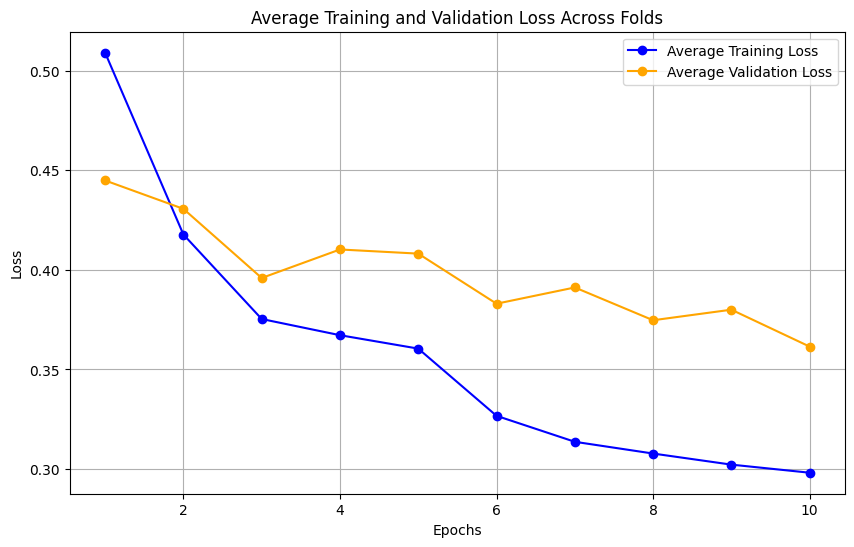

In [32]:
# DenseLayer or FinalClassifier
if isFinalClassifier:
    dense_layer_class = FinalClassifier
else:
    dense_layer_class = DenseLayer
    
output_dim = 768

# Run k-fold cross-validation   
results_df = cross_validate_model(
    dataset=full_dataset,
    model_class=SMCAModel,
    dense_layer_class=dense_layer_class,
    criterion=criterion,
    output_dim=output_dim,
    num_epochs=num_epochs_cv,    
    num_folds=num_folds,
    train_batch_size=train_batch_size,
    val_batch_size=val_batch_size,
    learning_rate=learning_rate,
    output_file="results/SMCA-F1_scores.csv"
)

In [33]:
results_df

,Metrics,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Average
0,Loss,0.417407,0.368194,0.342923,0.362495,0.316262,0.361456
1,Accuracy,0.818868,0.849057,0.875472,0.864151,0.864151,0.854340
2,Precision,0.690909,0.730769,0.830769,0.724138,0.745455,0.744408
3,Recall,0.550725,0.593750,0.710526,0.677419,0.650794,0.636643
4,F1 Score,0.612903,0.655172,0.765957,0.700000,0.694915,0.685790
